In [2]:
!pip install -q kaggle

In [4]:
#download kaggle.json
from google.colab import files
files.upload()

{}

In [5]:
!mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
!kaggle datasets download -d andrewmvd/hard-hat-detection

In [ ]:
!unzip hard-hat-detection.zip

In [ ]:
# storing file paths

ann_path = "/content/annotations"
img_path = "/content/images"

In [ ]:
print(img_path)

In [ ]:
# segregate the dataset into train & validation (there are 5000 images)(train:4500, val:500)

from pathlib import Path
path_annotations = []
for i in Path(ann_path).glob('*.xml'):
    path_annotations.append(i)
path_annotations = sorted(path_annotations) #contains path to 5000 annots

path_images = []
for i in Path(img_path).glob('*.png'):
    path_images.append(i)
path_images = sorted(path_images) #contains path to 5000 images

In [ ]:
# Split data : 60% Train, 20% Val 20%test
path_train_annot = path_annotations[:3000]
path_train_images = path_images[:3000]

path_val_annot = path_annotations[3000:4000]
path_val_images = path_images[3000:4000]

path_test_annot = path_annotations[4000:5000]
path_test_images = path_images[4000:5000]

In [ ]:
# making dirs to segregate train & val images & annotations & also to save best trained model
import os
file_path="/content/data"
# Creating directories to put train & val data
os.makedirs(file_path +'/train/annotations',exist_ok = True)
os.makedirs(file_path +'/train/images', exist_ok = True)
os.makedirs(file_path +'/val/annotations', exist_ok = True)
os.makedirs(file_path +'/val/images', exist_ok = True)
os.makedirs(file_path +'/test/annotations', exist_ok = True)
os.makedirs(file_path +'/test/images', exist_ok = True)
os.makedirs(file_path +'/savedmodel', exist_ok = True)

In [ ]:
# copying images & xml annotations from input to working folder
import shutil
from tqdm import tqdm

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_train_annot, path_train_images))):
    shutil.copy(path_img, file_path +'/train/images/' + path_img.parts[-1])
    shutil.copy(path_annot,file_path + '/train/annotations/' + path_annot.parts[-1])

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_val_annot, path_val_images))):
    shutil.copy(path_img, file_path +'/val/images/' + path_img.parts[-1])
    shutil.copy(path_annot, file_path +'/val/annotations/' + path_annot.parts[-1])

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_test_annot, path_test_images))):
    shutil.copy(path_img, file_path +'/test/images/' + path_img.parts[-1])
    shutil.copy(path_annot,file_path + '/test/annotations/' + path_annot.parts[-1])
# cpu 2min

In [ ]:
import torch
file_path="/content/data"
BATCH_SIZE = 8 #increase / decrease according to memeory
NUM_EPOCHS = 5 # number of epochs to train for
NUM_WORKERS = 0
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory

TRAIN_DIR =file_path + '/train'
# validation images and XML files directory
VALID_DIR = file_path + '/val'
# test images and XML files directory
test_DIR = file_path + '/test'

# classes: 0 index is reserved for background
CLASS_NAME = ['__background__', 'helmet', 'head', 'person']
NUM_CLASSES = len(CLASS_NAME)

In [ ]:
print(TRAIN_DIR)

In [ ]:
# Apply transform to image
import albumentations as A #new method, customizable transformations
from albumentations.pytorch import ToTensorV2

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc','label_fields': ['labels']}
    )

# define the validation transforms (validation data shud not be augmented)
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
# define the test transforms (test data shud not be augmented)
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

# The collate_fn() will help us take care of tensors of varying sizes while creating
# the training and validation data loaders.
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [ ]:
# Prepare the pytorch dataset

from torch.utils.data import Dataset, DataLoader
import glob, matplotlib.pyplot as plt, matplotlib.patches as patches
import xml.etree.ElementTree as ET
import pathlib
import cv2
from pathlib import Path

# foll is the class to create pytorch dataset from images(.png) & annotations(.xml)
class SafetyHelmDataset(Dataset):
    def __init__(self, dir_path, class_name, transforms=None):
        self.dir_path = dir_path
        self.class_name = class_name
        self.transforms = transforms

        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/images/*.png")
        self.all_images = sorted(self.image_paths)


    def __getitem__(self, idx: int):
        new_height=208
        new_width=208
        image_name = self.all_images[idx] #reading image one by one
        image = plt.imread(image_name) #read the image
        image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2))
        image /= 255.0 #normalize pixels b/w 0 & 1

        # capture the corresponding xml file for getting annotations
        annot_filepath = os.path.join(f'{self.dir_path}/annotations/', Path(image_name).parts[-1][:-4] + '.xml')

        boxes, labels = [], []
        root = ET.parse(annot_filepath).getroot() #reading xml file

        # extracting box coordinates from xml annotations
        for member in root.findall('object'):
            # map the current object name to classes to get the label index
            labels.append(self.class_name.index(member.find('name').text))

            # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
            xmin = int(member.find('bndbox').find('xmin').text)*(1/2)
            ymin = int(member.find('bndbox').find('ymin').text)*(1/2)
            xmax = int(member.find('bndbox').find('xmax').text)*(1/2)
            ymax = int(member.find('bndbox').find('ymax').text)*(1/2)

            boxes.append([xmin, ymin, xmax, ymax])

        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final target dict
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        image_id = torch.tensor([idx])
        target['image_id'] = image_id

        # apply image transforms
        if self.transforms:
            sample = self.transforms(image=image, bboxes=target['boxes'], labels=labels)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image, target #these are the o/p of this class


    def __len__(self):
        return len(self.all_images)

In [ ]:
# creating object of the class SafetyHelmetDataset which takes images & annotations folder,
# class_name & transformations as arguments & o/p image & bounding box coordinates &
# corresponding class_names

train_dataset = SafetyHelmDataset(TRAIN_DIR, CLASS_NAME, get_train_transform())
valid_dataset = SafetyHelmDataset(VALID_DIR, CLASS_NAME, get_valid_transform())
test_dataset = SafetyHelmDataset(test_DIR, CLASS_NAME, get_test_transform())



train_loader = DataLoader( #for loading data in batches, pytorch requires image as channel 1st e.g (3(channel),640(ht),480(wd))
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)
len(train_dataset), len(valid_dataset),len(test_dataset)


(3000, 1000, 1000)

In [ ]:
# functions to display samples a/w bounding box
import numpy as np, scipy
import os
def img_show(img, ax = None, figsize=(16,8)): #function to show image
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.tick_top()
    ax.imshow(img)
    return ax

def draw_box(img, ax, bb, lbl): #func to draw bounding box
    if lbl=='helmet':
        color_lbl='red'
    elif lbl=='head':
        color_lbl='yellow'
    else:
        color_lbl='blue'

    # rectangle draws bbox around the class
    rect = patches.Rectangle(
        (int(bb[0]),int(bb[1])), int(bb[2])-int(bb[0]), int(bb[3])-int(bb[1]),
        fill=False, edgecolor=color_lbl, lw=2
    )
    ax.add_patch(rect)


def plot_sample(a_img, tgt, ax=None, figsize=(16,8)):
    img = np.array(a_img).copy() #making deep copy for reproducibility (else if run 2nd time it gives err)
    img = img*255 #multiplying with 255 becoz in augmtn pixels r normalized
    img = np.transpose(img, (2,1,0)) #making channel 1st to channel last (i.e from (3,416,416) to (416,416,3))
    tr_img = scipy.ndimage.rotate(img, 270, reshape=False) #rotatg becoz rcvd img was hztlly left faced
    tr_img = np.flip(tr_img, axis=1) #mirroring the image becoz rcvd img was flipped
    ax = img_show(tr_img, ax=ax)

    for box_id in range(len(tgt['boxes'])):
        box = tgt['boxes'][box_id] #target['boxes'][box_id] contains (xmin, ymin, xmax, ymax) i.e bbox coor for each label
        lbl = CLASS_NAME[tgt['labels'][box_id]] #converting index back to str labels i.e 1 to 'helmet'
        draw_box(tr_img, ax, box, lbl) #drawing multiple bbox on single image using matplotlib

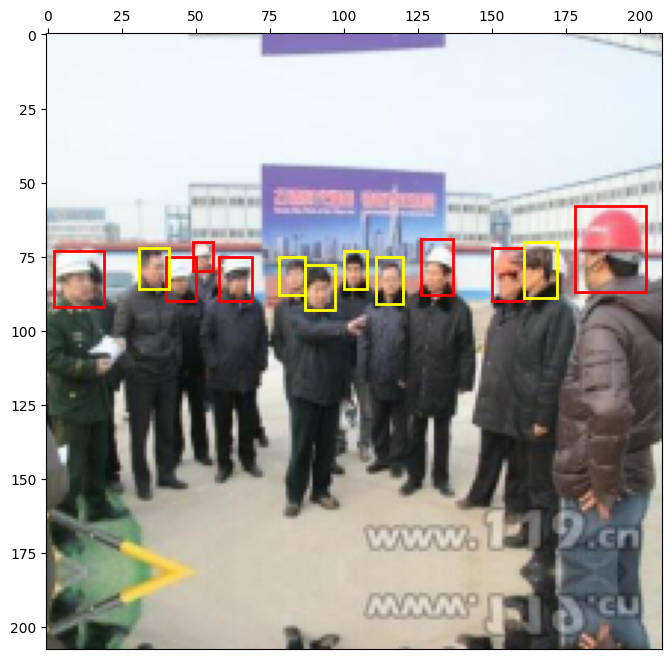

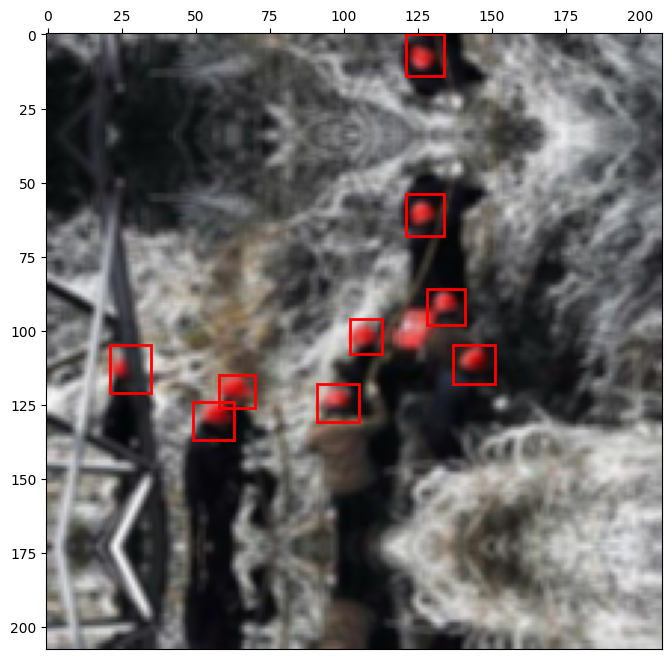

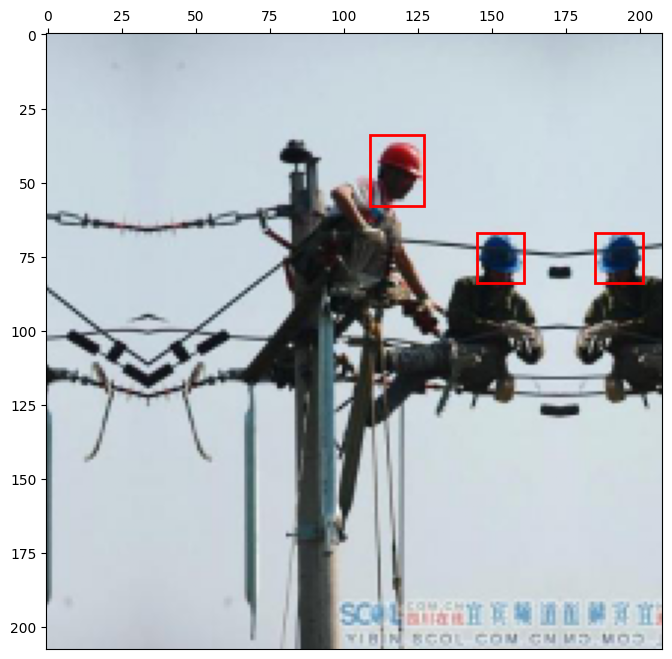

In [ ]:
# red=helmet, yellow=head
for i in range(3):
    a_img, trgt = train_dataset[i] #extracting image info from albumentated train dataset
    plot_sample(a_img, trgt) #a_img & trgt are float arrays

Faster RCNN Model

In [ ]:
# creating customised FasterRCNN model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# initialize the model and move to the computation device GPU
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]

# define the optimizer
# (this is the simple optimizer you can use other optimizer with callbacks for complex dataset)
# Create an instance of the RMSProp optimizer
optimizer = torch.optim.RMSprop(params, lr=0.005, momentum=0.9, weight_decay=0.001)


In [ ]:
# The training function always returns a list containing the training loss values
# for all the completed iterations

# function for running training iterations
def train(train_data_loader, model):
    print('Training...')
    global train_itr
    global train_loss_list

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [ ]:
# The validation function returns a similar list containing the loss values
# for all the completed iterations

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating...')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [ ]:
# this class keeps track of the training and validation loss values
# and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss

    def __call__(self, current_valid_loss, epoch, model, optimizer):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss:.3f}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/data/savedmodel/best_model.pth')


# function to save the model after each epoch and after training ends
def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/data/savedmodel/last_model.pth')

In [ ]:
import shutil
from tqdm import tqdm
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

# train and validation loss lists to store loss values of all
# iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# initialize SaveBestModel class
save_best_model = SaveBestModel()

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")

    # save the best model till now if we have the least loss in the current epoch
    save_best_model(val_loss_hist.value, epoch, model, optimizer)
    # save the current epoch model
    save_model(epoch, model, optimizer)


EPOCH 1 of 5
Training...


Loss: nan:   4%|▎         | 14/375 [27:30<11:33:40, 115.29s/it]